### 1️⃣ Pre-processing  

**Purpose:**  
Convert raw hardware output into clean, physiologically interpretable EEG signals suitable for analysis.

Raw EEG recordings are stored as amplifier ADC values. These must be converted and conditioned before any meaningful analysis can occur.

#### Steps:

1. **Scale ADC → µV**  
   - Convert amplifier units into microvolts  
   - Ensures physiological interpretability  
   - Standardizes units across recordings  

2. **Trim to Valid Experiment Window (Study-Specified)**  
   - Removes non-experimental segments  
   - Excludes high-noise transitions  
   - Ensures analysis focuses only on controlled task periods  

3. **Bandpass Filter (1–40 Hz)**  
   - Removes slow drift (<1 Hz)  
   - Removes high-frequency muscle artifacts (>40 Hz)  
   - Preserves canonical EEG rhythms (delta–gamma)  

At the end of preprocessing, the signal represents cleaned, task-aligned EEG data in physiological units.

---

### 2️⃣ Validation (Diagnostic Only)

**Purpose:**  
Demonstrate that the custom preprocessing pipeline replicates the study’s provided filtered signals.

This step ensures the modeling pipeline is built on correctly processed data.

#### Steps:

1. **Validation Against Provided `Filtered_Data`**
   - Compute Pearson correlation per channel  
   - Compute mean absolute difference  
   - Confirm waveform structure and phase alignment  

2. **Gain Factor Analysis (Visual + Quantitative)**
   - Compute channel-wise amplitude scaling factors  
   - Confirm amplitude differences are linear (approximately constant across channels)  
   - Attribute discrepancies to unit scaling rather than filtering error  

This stage is diagnostic only and is not used during feature extraction or classification.

---

### 3️⃣ Epoching (Segmentation)

**Purpose:**  
EEG is nonstationary. Features must be extracted from short, quasi-stable time windows.

Continuous EEG recordings are segmented into:

- 2-second windows  
- 1-second overlap  

This:

- Increases sample size  
- Improves stationarity  
- Enables consistent feature extraction  
- Prevents modeling on unstable long-duration signals  

Each epoch becomes one training sample.

---

### 4️⃣ Feature Extraction (Brain Representation)

**Purpose:**  
Transform waveform data into structured, physiologically meaningful descriptors suitable for machine learning.

Each epoch is converted into a feature vector composed of:

#### Frequency-Domain Features
- Absolute band power (delta, theta, alpha, beta, gamma)  
- Relative band power  

These quantify oscillatory brain dynamics.

#### Time-Domain Features
- Hjorth Activity (signal variance)  
- Hjorth Mobility (frequency proxy)  
- Hjorth Complexity (signal irregularity)  

These capture waveform dynamics beyond spectral power.

#### Complexity Features
- Spectral entropy  

Measures distribution of power across frequencies (signal organization vs randomness).

After feature extraction:

Raw waveform (samples × channels)
↓
Structured numerical feature vector

---

### 5️⃣ Classification (Condition Modeling)

**Purpose:**  
Determine whether extracted EEG features encode experimental condition differences.

#### Pipeline:

1. Build feature matrix (X) and labels (y)  
2. Standardize features  
3. Train Random Forest classifier  
4. Evaluate using stratified cross-validation  

This tests:

> Can condition be predicted from EEG-derived features?

The final output is a cross-validated classification accuracy representing how separable the experimental conditions are in feature space.

---

## Full Pipeline Summary

Raw EEG
↓
Pre-processing
↓
Validation (diagnostic)
↓
Epoching
↓
Feature Extraction
↓
Classification
↓
Condition Accuracy

## Notes / References
- Jurcak V, Tsuzuki D, Dan I. 10/20, 10/10, and 10/5 systems revisited: their validity as relative head-surface-based positioning systems. Neuroimage. 2007 Feb 15;34(4):1600-11.
Altahat SH. Robust EEG Channel Set for Biometric Application (Doctoral dissertation, University of Canberra).
Ravi KV, Palaniappan R. A minimal channel set for individual identification with EEG biometric using genetic algorithm. InInternational Conference on Computational Intelligence and Multimedia Applications (ICCIMA 2007) 2007 Dec 13 (Vol. 2, pp. 328-332). IEEE.
Marcel S, Millán JD. Person authentication using brainwaves (EEG) and maximum a posteriori model adaptation. IEEE transactions on pattern analysis and machine intelligence. 2007 Feb 20;29(4):743-52.
World Medical Association. World Medical Association Declaration of Helsinki. Ethical principles for medical research involving human subjects. Bulletin of the World Health Organization. 2001;79(4):373.


## Import Libraries and Set Paths

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import pandas as pd

## 1️⃣ Signal Pre-processing & 2️⃣ Validation

Its clear that the raw data has noise. We can intoduce a bandpass filter to remove low frequencies and very high frequencies. 

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
from pathlib import Path
import matplotlib.pyplot as plt

# =========================================
# Constants 
# =========================================
FS = 200  # Sampling rate in Hz
CANONICAL_CHANNELS = ['T7', 'F8', 'Cz', 'P4']  # EEG channels
SCALE_FACTOR = 15686 / 8388607  # µV per LSB (Ganglion ADC)

# =========================================
# Paths to data
# =========================================
raw_dir = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/Raw_Data")  # Raw EEG Signal
trim_file = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/data_trim.csv")  # Trim points
filtered_dir = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/Filtered_Data")  # Reference data

# =========================================
# Trim Utilities
# =========================================
def load_trim_file(trim_file):
    """
    Load the data_trim.csv file containing segmentation indices.

    Parameters
    ----------
    trim_file : str or Path
        Path to data_trim.csv.

    Returns
    -------
    trim_df : pandas.DataFrame
        DataFrame containing trimming information.
    """
    trim_df = pd.read_csv(trim_file)
    expected_cols = {'Subject', 'Experment', 'session', 'From (n)', 'To (n)'}
    missing = expected_cols - set(trim_df.columns)

    if missing:
        raise ValueError(f"Missing columns in data_trim.csv: {missing}")
    
    # Forward fill missing subject/experiment values
    trim_df['Subject'] = trim_df['Subject'].ffill().astype(int)
    trim_df['Experment'] = trim_df['Experment'].ffill().astype(int)
    trim_df['session'] = trim_df['session'].astype(int)
    
    return trim_df

def get_trim_indices(trim_df, subject, experiment, session):
    """
    Retrieve start and end sample indices for segmented EEG.

    Returns
    -------
    start, end : int
        Sample indices for trimming raw EEG.
    """
    row = trim_df[
        (trim_df['Subject'] == subject) &
        (trim_df['Experment'] == experiment) &
        (trim_df['session'] == session)
    ]
    if row.empty:
        raise ValueError(f"No trim info for Subject {subject}, Experiment {experiment}, Session {session}")
    start_sample = int(row['From (n)'].values[0])
    end_sample = int(row['To (n)'].values[0])
    return start_sample, end_sample

# =========================================
# Preprocessing
# =========================================
# def remove_dc_offset(eeg):
#     """Remove DC offset (zero-mean per channel)"""
#     return eeg - np.mean(eeg, axis=0, keepdims=True)

def bandpass_1_40hz(eeg, fs=FS):
    """
    Apply 1st-order Butterworth bandpass filter (1–40 Hz).

    Matches the filtering described in the dataset README.
    """
    low, high = 1, 40
    b, a = butter(N=1, Wn=[low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, eeg, axis=0)

def notch_50hz(eeg, fs=FS):
    """
    Apply 50 Hz notch filter (Q=30).

    Removes power line interference as described in the study.
    """
    f0 = 50
    Q = 30
    b, a = iirnotch(f0/(fs/2), Q)
    return filtfilt(b, a, eeg, axis=0)

def preprocess_eeg(eeg):
    """
    Full preprocessing pipeline:
        1. DC offset removal
        2. 1–40 Hz bandpass
        3. 50 Hz notch filter

    Returns
    -------
    eeg : np.ndarray
        Preprocessed EEG (samples × channels)
    """
    eeg = bandpass_1_40hz(eeg)
    eeg = notch_50hz(eeg)    
    return eeg

# def rereference_average(eeg):
#     """Average reference across channels. Removes channel biases."""
#     return eeg - np.mean(eeg, axis=1, keepdims=True)

# =========================================
# LOAD + PREPROCESS
# =========================================
def load_and_preprocess(raw_file, trim_df, subject, experiment, session):
    """
    Load raw EEG file, trim to clean 2-minute segment,
    scale to µV, and apply preprocessing filters.

    Parameters
    ----------
    raw_file : str or Path
        Path to raw EEG CSV file.
    trim_df : pandas.DataFrame
        Trim index table.
    subject : int
    experiment : int
    session : int

    Returns
    -------
    eeg : np.ndarray
        Cleaned EEG signal (samples × 4 channels)
    """
    df = pd.read_csv(raw_file)
    df.columns = df.columns.str.strip()

    raw_map = {
        'EXG Channel 0': 'T7',
        'EXG Channel 1': 'F8',
        'EXG Channel 2': 'Cz',
        'EXG Channel 3': 'P4'
    }
    df = df.rename(columns=raw_map)

    eeg = df[CANONICAL_CHANNELS].to_numpy() * SCALE_FACTOR

    start, end = get_trim_indices(trim_df, subject, experiment, session)
    eeg = eeg[start:end]

    eeg = preprocess_eeg(eeg)

    return eeg

# =========================================
# Gain Matching (Validation Only)
# =========================================
def match_reference_gain(my_eeg, ref_eeg, method="max"):
    """
    Match amplitude scale of processed EEG to reference EEG.

    Parameters
    ----------
    method : str
        'rms' or 'max'

    Returns
    -------
    scaled_eeg : np.ndarray
    gain : np.ndarray
        Channel-wise gain factors applied.
    """
    if method == "rms":
        my_amp = np.sqrt(np.mean(my_eeg**2, axis=0))
        ref_amp = np.sqrt(np.mean(ref_eeg**2, axis=0))
    elif method == "max":
        my_amp = np.max(np.abs(my_eeg), axis=0)
        ref_amp = np.max(np.abs(ref_eeg), axis=0)
    else:
        raise ValueError("method must be 'rms' or 'max'")

    gain = ref_amp / my_amp
    return my_eeg * gain, gain

def validate_against_reference(my_eeg, reference_file, apply_gain=False, method="rms"):
    """
    Compare preprocessed EEG against provided Filtered_Data file.

    Computes:
        - Pearson correlation
        - Mean absolute difference

    Optionally applies gain normalization before comparison.

    Returns
    -------
    validated_eeg : np.ndarray
        Possibly gain-adjusted EEG (for inspection only).
    """
    df_ref = pd.read_csv(reference_file)
    ref = df_ref[CANONICAL_CHANNELS].to_numpy()

    n = min(len(my_eeg), len(ref))
    my_eeg = my_eeg[:n]
    ref = ref[:n]

    if apply_gain:
        my_eeg, gain = match_reference_gain(my_eeg, ref, method=method)
        print(f"\nGain factors applied ({method}): {gain}")

    print("\nValidation Results")
    for ch, name in enumerate(CANONICAL_CHANNELS):
        corr = np.corrcoef(my_eeg[:, ch], ref[:, ch])[0, 1]
        diff = np.mean(np.abs(my_eeg[:, ch] - ref[:, ch]))
        print(f"{name}: Corr={corr:.6f} | MeanAbsDiff={diff:.4f} µV")

    return my_eeg

# # =========================================
# # Load EEG
# # =========================================
# def load_and_preprocess_eeg(
#         raw_file, trim_df, subject, 
#         experiment, session, 
#         reference_file=None, 
#         apply_gain_match=False, 
#         gain_method="rms",
#         apply_avg_ref=False
#     ):
#     """
#     Load raw EEG file and preprocess to match PhysioNet Filtered_Data.
    
#     Returns:
#     - sample_idx: np.ndarray of sample indices
#     - eeg: np.ndarray of preprocessed EEG (n_samples x 4 channels)
#     """
#     # Load raw file
#     df = pd.read_csv(raw_file)
#     df.columns = df.columns.str.strip()

#     # Map ADC channels to canonical names
#     raw_channel_map = {
#         'EXG Channel 0':'T7', 
#         'EXG Channel 1':'F8', 
#         'EXG Channel 2':'Cz', 
#         'EXG Channel 3':'P4'
#     }
#     df = df.rename(columns=raw_channel_map)

#     # Check channels
#     missing = set(CANONICAL_CHANNELS) - set(df.columns)
#     if missing:
#         raise ValueError(f"Missing channels in raw file: {missing}")

#     # Extract sample indices and EEG
#     sample_idx = df.iloc[:, 0].to_numpy()
#     eeg = df[CANONICAL_CHANNELS].to_numpy()

#     # --- Scale ADC → µV ---
#     eeg = eeg * SCALE_FACTOR

#     # --- Remove DC offset and apply Filters---
#     eeg = remove_dc_offset(eeg)
#     eeg = preprocess_eeg(eeg)

#     # Average reference
#     if apply_avg_ref: 
#         eeg = rereference_average(eeg)

#     # --- Trim to clean 2-minute segment ---
#     start, end = get_trim_indices(trim_df, subject, experiment, session)
#     sample_idx = sample_idx[start:end]
#     eeg = eeg[start:end, :]
    
#     # --- Perform Gain Match ---
#     if apply_gain_match: 
#         if reference_file is None:
#             raise ValueError("reference_file must be provided for gain matching.")
        
#         ref = load_filtered_reference(reference_file)
#         ref = ref[:len(eeg)] # align length

#         eeg, gain = match_reference_gain(eeg, ref, method=gain_method)
#     return sample_idx, eeg

# # =========================================
# # Load Filtered Reference
# # =========================================
# def load_filtered_reference(file_path):
#     """Load PhysioNet filtered EEG in canonical channel order."""
#     df = pd.read_csv(file_path)
#     missing = set(CANONICAL_CHANNELS) - set(df.columns)
#     if missing:
#         raise ValueError(f"Missing channels in filtered file: {missing}")
#     return df[CANONICAL_CHANNELS].to_numpy()

# =========================================
# Plotting
# =========================================
def plot_eeg_signal(eeg, channel=0, window=None):
    """Plot a single EEG channel by itself"""
    ch_name = CANONICAL_CHANNELS[channel]
    signal = eeg[:, channel]
    if window is not None:
        signal = signal[:window]
    plt.figure(figsize=(12,4))
    plt.plot(signal, label=ch_name, color='tab:blue')
    plt.title(f"EEG Signal: {ch_name}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (µV)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def compare_with_reference(eeg, reference_file, channel=0, window=None, show_diff=True, show_corr=True, offset_gap=50):
    """
    Compare one EEG channel to PhysioNet filtered reference.

    Parameters
    ----------
    my_eeg : np.ndarray
        Preprocessed EEG (samples x channels)
    reference_file : str or Path
        Path to PhysioNet Filtered_Data CSV
    channel : int
        Channel index (0=T7, 1=F8, 2=Cz, 3=P4)
    window : int or None
        Number of samples to display
    show_diff : bool
        Whether to show difference plot
    show_corr : bool
        Whether to compute and display correlation
    """
    # Define reference channel 
    df_ref = pd.read_csv(reference_file)
    ch_name = CANONICAL_CHANNELS[channel]

    ref = df_ref[ch_name].to_numpy()
    my = eeg[:, channel]

    # Zoom window if requested
    if window is not None:
        my = my[:window]
        ref = ref[:window]

    n = min(len(my), len(ref))
    my = my[:n]
    ref = ref[:n]

    # Apply vertical offset for plotting
    my_offset = my + offset_gap

    plt.figure(figsize=(12,4))
    plt.plot(my_offset, label=f"My Ch {ch_name} + {offset_gap} uV", alpha=0.7)
    plt.plot(ref, label=f"Ref Ch {ch_name} uV", alpha=0.7)
    plt.title(f"{ch_name} Comparison")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (µV)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if show_diff:
        diff = my - ref
        plt.figure(figsize=(12,4))
        plt.plot(diff)
        plt.title(f"Difference: {ch_name} (My − Ref)")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude Difference (µV)")
        plt.tight_layout()
        plt.show()
        print(f"{ch_name} max diff: {np.max(np.abs(diff)):.5f} µV | mean diff: {np.mean(diff):.5f} µV")

    if show_corr:
        corr = np.corrcoef(my, ref)[0,1]
        print(f"{ch_name} correlation: {corr:.6f}")



Gain factors applied (rms): [540.01715601 536.35089934 542.86721262 534.10360799]

Validation Results
T7: Corr=0.886351 | MeanAbsDiff=1.3595 µV
F8: Corr=0.960316 | MeanAbsDiff=1.5553 µV
Cz: Corr=0.904610 | MeanAbsDiff=1.3892 µV
P4: Corr=0.907138 | MeanAbsDiff=1.2437 µV


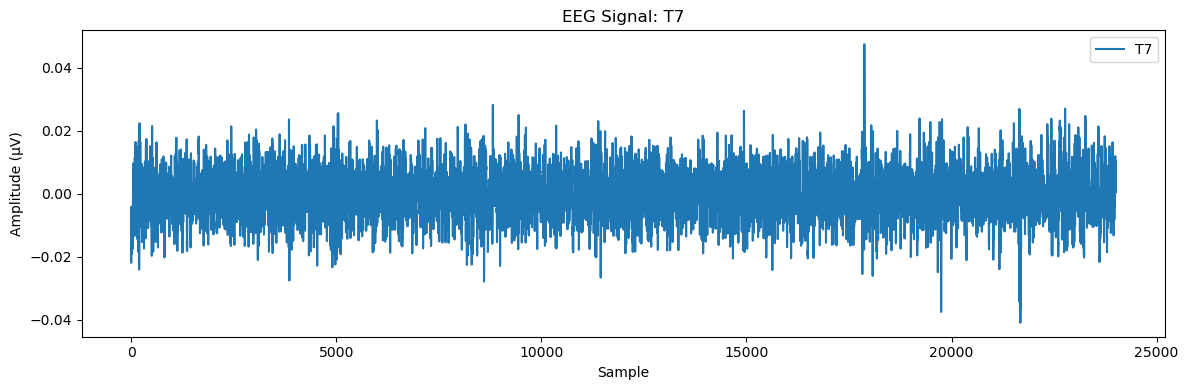

In [3]:
# Preprocess raw EEG like PhysioNet
trim_df = load_trim_file(trim_file)

subject = 1
experiment = 1   # numeric, as in data_trim.csv
session = 1

raw_file = raw_dir / "ex01" / "s01_ex01_s01.txt"
ref_file = filtered_dir / "s01_ex01_s01.csv"

# 1️⃣ Pure preprocessing (N validation inside)
eeg_proc = load_and_preprocess(
    raw_file, 
    trim_df, 
    subject=subject, 
    experiment=experiment, 
    session=session, 
)

# 2️⃣ Validation step (Compare channels and match gain)
eeg_validated = validate_against_reference(
    eeg_proc,
    reference_file=ref_file,
    apply_gain=True,        # Only for validation
    method="rms",
)

# Plot T7
plot_eeg_signal(eeg_proc, channel=0)


Gain factors: [540.01715601 536.35089934 542.86721262 534.10360799]


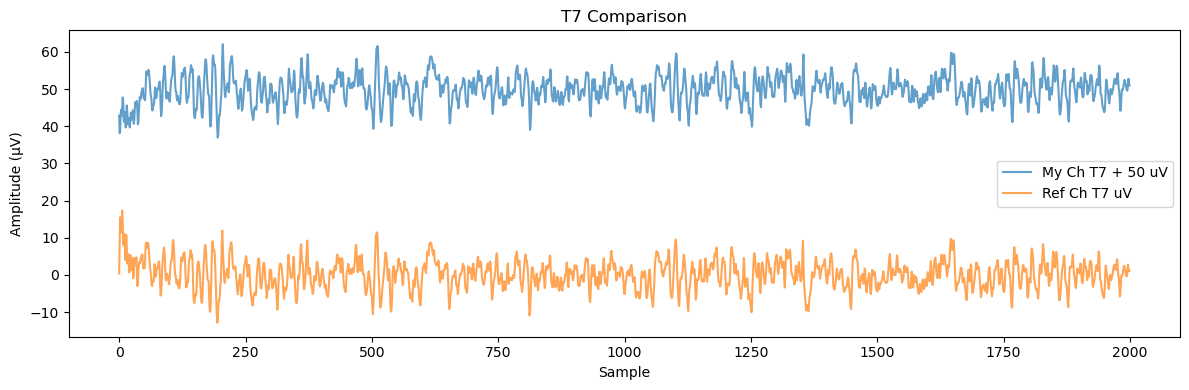

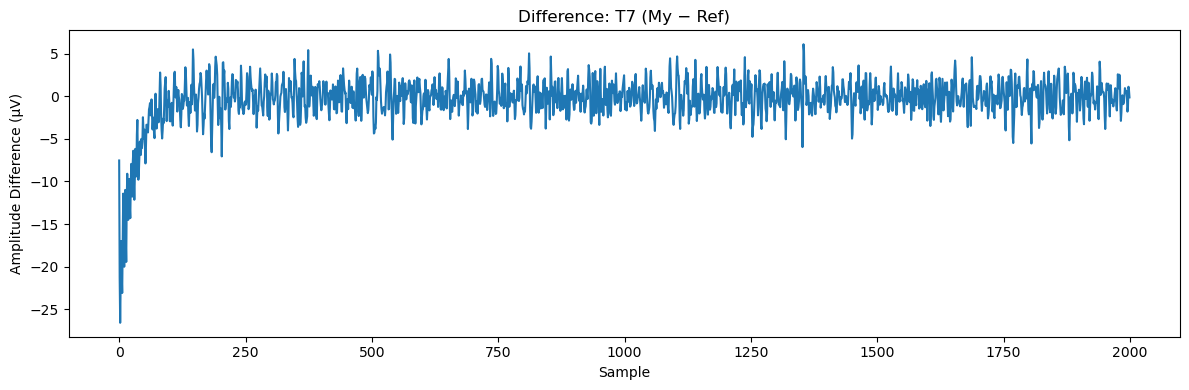

T7 max diff: 26.59921 µV | mean diff: -0.34824 µV


In [4]:
# --- Load reference ---
df_ref = pd.read_csv(ref_file)
ref_eeg = df_ref[CANONICAL_CHANNELS].to_numpy()

# --- Gain match using max amplitude ---
eeg_scaled, gain = match_reference_gain(eeg_proc, ref_eeg, method="rms")
print("Gain factors:", gain)

# --- Visual comparison ---
compare_with_reference(
    eeg_scaled,
    reference_file=ref_file,
    channel=0,
    window=10 * FS,
    show_diff=True,
    show_corr=False
)

The Pre-processing steps have been deduced to be as  for the Physionet dataset: 

Raw EEG
 ↓
Bandpass Filter (0.5–40 Hz)
 ↓
Amplification (gain matching)

The amplication is typically done the hardware scaling. The filtered EEGs are already scaled while the raw amplifier units are not scaled. To best match it to validate the pre-processing I performed a gain match using RMS difference. 
They should not be identically but highly correlated with eachother which they are. 

Validation Results
T7: Corr=0.886351 | MeanAbsDiff=1.3595 µV
F8: Corr=0.960316 | MeanAbsDiff=1.5553 µV
Cz: Corr=0.904610 | MeanAbsDiff=1.3892 µV
P4: Corr=0.907138 | MeanAbsDiff=1.2437 µV

Gain factors: [540.01715601 536.35089934 542.86721262 534.10360799]

These results let us know how the pre-processing conducted by me is very similar to Physionets pre-processing. The consistent Gain factors also demonstrate that trend across the channels.

There is a suggested pipeline for [EEG pre-processing] (https://www.frontiersin.org/journals/neuroinformatics/articles/10.3389/fninf.2015.00016/full):
1. Apply Filters ✅
2. Re-reference 
3. Reject Artifacts
4. Select Window Sizes ✅ 
5. Frequency Domain Decomposition
6. Average

The study has already done filter application with a Bandpass and Notch filter. They selected trim points that have minimal noise during the performed events. These steps are steps 1 and 4.

Steps 2 and 3 are not needed because re-referencing would alter our validation. Since we already selected a window where some 'event' occured there is no need to unintentionally remove important eye blinks or signal from listening to music.


In [5]:
# --- Comparison plot with overlay for all channels ---
CHANNELS = ['T7', 'F8', 'Cz', 'P4']

def compare_all_channels_overlay(my_eeg):
    """
    Overlay all EEG channels (stacked) comparing custom preprocessing
    vs PhysioNet filtered reference.
    
    Parameters
    ----------
    my_eeg : np.ndarray
        Preprocessed EEG (samples x channels)
    reference_file : str or Path
        Path to PhysioNet Filtered_Data CSV
    """

    n_channels = my_eeg.shape[1]

    # Dynamic vertical offset
    offset = 8 * np.nanstd(my_eeg)

    plt.figure(figsize=(14, 7))

    for ch in range(n_channels):
        y_offset = ch * offset

        plt.plot(
            my_eeg[:, ch] + y_offset,
            color=f"C{ch}",
            label=CHANNELS[ch]
        )

    # Channel labels centered on offsets
    yticks = [ch * offset for ch in range(n_channels)]
    plt.yticks(yticks, CHANNELS)

    # 
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (µV) + offset")
    plt.title("EEG Overlay")

    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


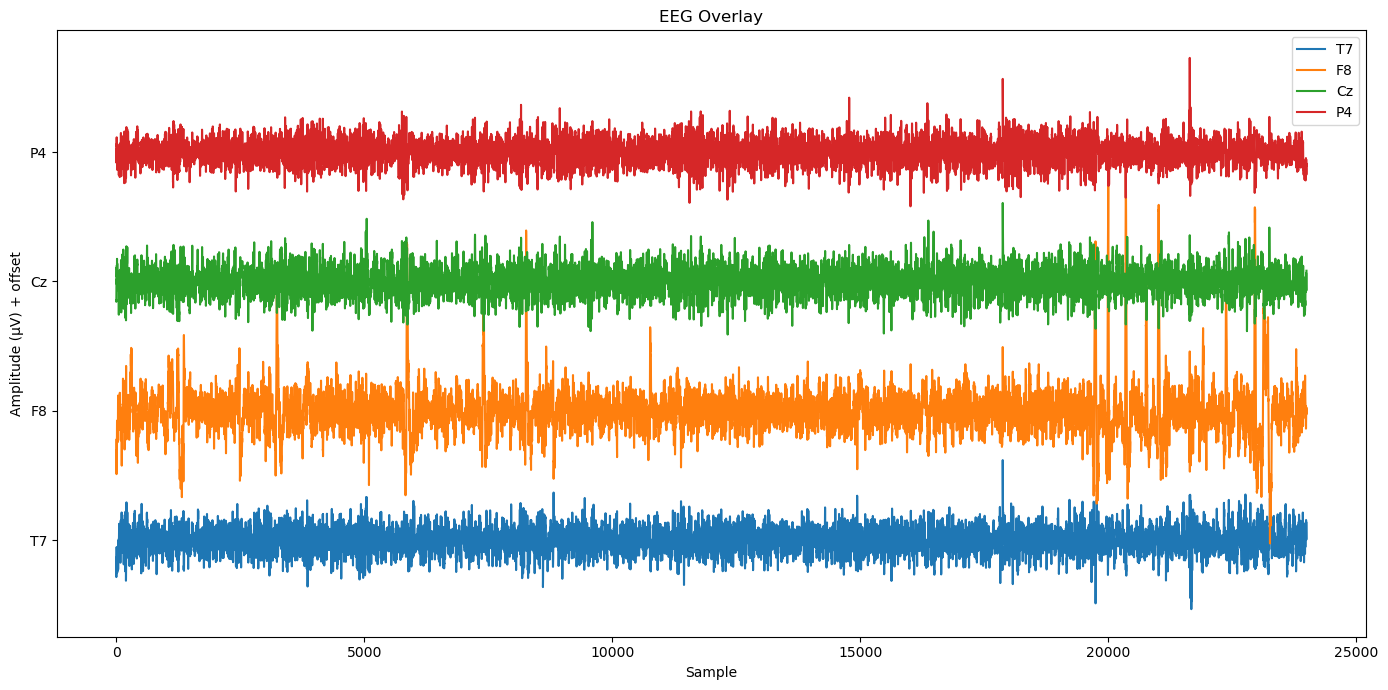

In [6]:
compare_all_channels_overlay(my_eeg=eeg_proc)

## 3️⃣ Epoching

We need to convert the continous EEG (samples x channels) into Epochs (n_epochs x epoch_samples x channels).

As a result we get a structured training sample.

In [7]:
def epoch_eeg(
        eeg: np.ndarray, 
        fs:int, 
        epoch_length_sec: float = 2.0, 
        overlap_sec: float= 1.0
        ) -> np.ndarray:
    """
    Segment continuous EEG into overlapping epochs.

    Parameters
    ----------
    eeg : np.ndarray
        Continuous EEG signal of shape (n_samples, n_channels).
    fs : int
        Sampling frequency in Hz.
    epoch_length_sec : float, optional
        Length of each epoch in seconds (default = 2.0).
    overlap_sec : float, optional
        Overlap between consecutive epochs in seconds (default = 1.0).

    Returns
    -------
    epochs : np.ndarray
        Array of shape (n_epochs, epoch_samples, n_channels).
    """

    # Define np.array check 
    if eeg.ndim != 2:
        raise ValueError("EEG must be a 2D array of shape (n_samples, n_channels)")
    
    epoch_samples = int(epoch_length_sec * fs)
    step_samples = int((epoch_length_sec - overlap_sec) * fs)

    # Define check for positive step size
    if step_samples <= 0:
        raise ValueError("Overlap must be less than epoch length to ensure positive step size.")
    
    n_samples, n_channels = eeg.shape
    epochs = []

    for start in range(0, n_samples - epoch_samples + 1, step_samples):
        end = start + epoch_samples
        epochs.append(eeg[start:end, :])
    
    epochs = np.stack(epochs)  # Shape: (n_epochs, epoch_samples, n_channels)
    
    return epochs

In [8]:
epochs = epoch_eeg(eeg_proc, fs=FS, epoch_length_sec=2.0, overlap_sec=1.0)

print(f"Epochs shape: {epochs.shape} (n_epochs, epoch_samples, n_channels)")

Epochs shape: (119, 400, 4) (n_epochs, epoch_samples, n_channels)


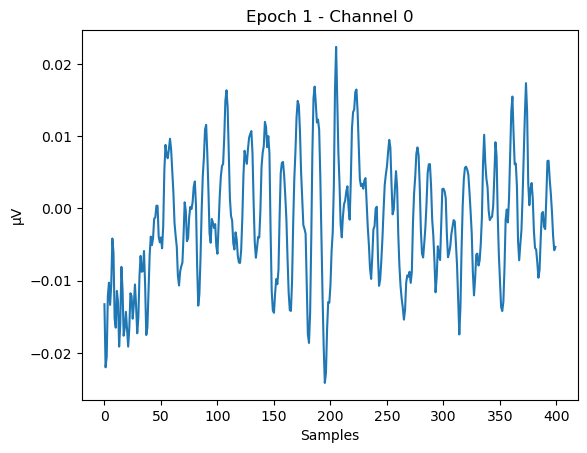

In [9]:
# Sanity check
import matplotlib.pyplot as plt

# Plot first epoch, first channel
plt.plot(epochs[0, :, 0])
plt.title("Epoch 1 - Channel 0")
plt.xlabel("Samples")
plt.ylabel("µV")
plt.show()

Converted the following:

* 1 long signal → many structured training samples
* Made EEG locally stationary
* Increased dataset size
* Enabled feature extraction per window

## 4️⃣ Feature Extraction

Will build a function extract_features() that converts:

(n_epochs, epoch_samples, n_channels) into (n_epochs, n_features)

This will include:
* Absolute band power
* Relative band power
* Hjorth Parameters
* Spectral Entropy

| Feature Type        | Question It Answers                              |
| ------------------- | ------------------------------------------------ |
| Absolute Band Power | How strong is oscillation X?                     |
| Relative Band Power | What percentage of activity is oscillation X?    |
| Hjorth Activity     | How large is the signal overall?                 |
| Hjorth Mobility     | How fast is the signal changing?                 |
| Hjorth Complexity   | How irregular is the waveform?                   |
| Spectral Entropy    | How organized vs noisy is the frequency content? |

All per channel

Nayak, C. S., & Anilkumar, A. C. (2019, March 24). EEG Normal Waveforms. Nih.gov; StatPearls Publishing. https://www.ncbi.nlm.nih.gov/books/NBK539805/

Safi, M. S., & Safi, S. M. M. (2021). Early detection of Alzheimer’s disease from EEG signals using Hjorth parameters. Biomedical Signal Processing and Control, 65, 102338. https://doi.org/10.1016/j.bspc.2020.102338

### Helper Functions

In [10]:
import numpy as np
from scipy.signal import welch
from scipy.stats import entropy


def compute_band_powers(signal, fs, bands):
    """
    Compute absolute and relative band power using Welch PSD.

    Parameters
    ----------
    signal : np.ndarray
        1D EEG signal (samples,)
    fs : int
        Sampling frequency
    bands : dict
        Dictionary of frequency bands {name: (low, high)}

    Returns
    -------
    abs_powers : dict
        Absolute band power per band
    rel_powers : dict
        Relative band power per band
    """
    freqs, psd = welch(signal, fs=fs, nperseg=fs*2)

    total_power = np.trapezoid(psd, freqs)

    abs_powers = {}
    rel_powers = {}

    for band_name, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        band_power = np.trapezoid(psd[idx], freqs[idx])

        abs_powers[band_name] = band_power
        rel_powers[band_name] = band_power / total_power if total_power > 0 else 0

    return abs_powers, rel_powers


def hjorth_parameters(signal):
    """
    Compute Hjorth Activity, Mobility, and Complexity.

    Returns
    -------
    activity : float
    mobility : float
    complexity : float
    """
    first_deriv = np.diff(signal)
    second_deriv = np.diff(first_deriv)

    var_zero = np.var(signal)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)

    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero) if var_zero > 0 else 0
    complexity = (
        np.sqrt(var_d2 / var_d1) / mobility
        if var_d1 > 0 and mobility > 0
        else 0
    )

    return activity, mobility, complexity


def spectral_entropy_feature(signal, fs):
    """
    Compute normalized spectral entropy.
    """
    freqs, psd = welch(signal, fs=fs)
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    return entropy(psd_norm)

### Main Feature Extraction Function

In [11]:
def extract_features(epochs, fs):
    """
    Extract features from EEG epochs.

    Parameters
    ----------
    epochs : np.ndarray
        Shape (n_epochs, epoch_samples, n_channels)
    fs : int
        Sampling frequency

    Returns
    -------
    features : np.ndarray
        Shape (n_epochs, n_features)
    """

    bands = {
        "delta": (1, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "beta": (13, 30),
        "gamma": (30, 60),
    }

    n_epochs, _, n_channels = epochs.shape
    all_features = []

    for ep in range(n_epochs):
        epoch_features = []

        for ch in range(n_channels):
            signal = epochs[ep, :, ch]

            # --- Frequency features ---
            abs_powers, rel_powers = compute_band_powers(signal, fs, bands)

            for band in bands:
                epoch_features.append(abs_powers[band])
            for band in bands:
                epoch_features.append(rel_powers[band])

            # --- Time-domain features ---
            activity, mobility, complexity = hjorth_parameters(signal)
            epoch_features.extend([activity, mobility, complexity])

            # --- Complexity feature ---
            spec_ent = spectral_entropy_feature(signal, fs)
            epoch_features.append(spec_ent)

        all_features.append(epoch_features)

    return np.array(all_features)

We have:
* 4 channels
* 5 bands

Features per channel:
* 5 absolute
* 5 relative
* 3 Hjorth
* 1 entropy
= 14 features per channel

The shape of the Feature matrix should be:

4 channels x 14 = 56 features per epoch

(n_epochs, 56)

In [12]:
X = extract_features(epochs, fs=FS)

print("Feature matrix shape:", X.shape)

Feature matrix shape: (119, 56)


In [13]:
def get_feature_names(n_channels):
    """
    Generate feature names in the same order as extract_features().
    """
    bands = ["delta", "theta", "alpha", "beta", "gamma"]
    names = []

    for ch in range(n_channels):
        prefix = f"ch{ch}"

        # Absolute power
        for band in bands:
            names.append(f"{prefix}_abs_{band}")

        # Relative power
        for band in bands:
            names.append(f"{prefix}_rel_{band}")

        # Hjorth
        names.append(f"{prefix}_hjorth_activity")
        names.append(f"{prefix}_hjorth_mobility")
        names.append(f"{prefix}_hjorth_complexity")

        # Entropy
        names.append(f"{prefix}_spectral_entropy")

    return names

In [14]:
import pandas as pd

feature_names = get_feature_names(n_channels=epochs.shape[2])

df_features = pd.DataFrame(X, columns=feature_names)

df_features.head()

,ch0_abs_delta,ch0_abs_theta,ch0_abs_alpha,ch0_abs_beta,ch0_abs_gamma,ch0_rel_delta,ch0_rel_theta,ch0_rel_alpha,ch0_rel_beta,ch0_rel_gamma,...,ch3_abs_gamma,ch3_rel_delta,ch3_rel_theta,ch3_rel_alpha,ch3_rel_beta,ch3_rel_gamma,ch3_hjorth_activity,ch3_hjorth_mobility,ch3_hjorth_complexity,ch3_spectral_entropy
0,0.000005,0.000012,0.000041,0.000023,0.000002,0.062333,0.138674,0.470871,0.270539,0.026644,...,0.000001,0.082884,0.056301,0.374586,0.425373,0.024683,0.000040,0.479812,1.728520,3.312929
1,0.000005,0.000010,0.000010,0.000016,0.000003,0.105231,0.216079,0.216355,0.366740,0.062953,...,0.000002,0.260963,0.111996,0.266514,0.218260,0.052992,0.000033,0.443403,2.112736,3.370335
2,0.000021,0.000007,0.000016,0.000011,0.000002,0.358878,0.124245,0.274941,0.189632,0.037187,...,0.000002,0.246970,0.162630,0.285529,0.197308,0.077313,0.000025,0.466910,2.164751,3.543832
3,0.000004,0.000002,0.000011,0.000011,0.000002,0.137550,0.068996,0.346846,0.343108,0.076609,...,0.000001,0.089888,0.137363,0.456816,0.203596,0.068562,0.000026,0.458825,2.102876,3.377964
4,0.000008,0.000006,0.000011,0.000009,0.000002,0.222944,0.150495,0.308556,0.246049,0.055893,...,0.000001,0.138039,0.149617,0.302363,0.320365,0.044483,0.000040,0.456091,1.844830,3.432679


In [15]:
df_features.describe()

,ch0_abs_delta,ch0_abs_theta,ch0_abs_alpha,ch0_abs_beta,ch0_abs_gamma,ch0_rel_delta,ch0_rel_theta,ch0_rel_alpha,ch0_rel_beta,ch0_rel_gamma,...,ch3_abs_gamma,ch3_rel_delta,ch3_rel_theta,ch3_rel_alpha,ch3_rel_beta,ch3_rel_gamma,ch3_hjorth_activity,ch3_hjorth_mobility,ch3_hjorth_complexity,ch3_spectral_entropy
count,1.190000e+02,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,...,1.190000e+02,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,1.013872e-05,0.000008,0.000020,0.000011,0.000003,0.185305,0.152795,0.370311,0.214349,0.050152,...,1.965503e-06,0.139531,0.125698,0.467673,0.190950,0.044720,0.000050,0.424657,1.974175,3.070859
std,8.752121e-06,0.000004,0.000012,0.000004,0.000003,0.115971,0.062150,0.143887,0.070301,0.029631,...,2.867132e-06,0.092370,0.062788,0.201922,0.087078,0.045853,0.000020,0.081859,0.156886,0.394418
min,8.961554e-07,0.000002,0.000003,0.000005,0.000001,0.033876,0.047396,0.055617,0.075746,0.012629,...,9.257713e-07,0.006536,0.013823,0.047958,0.065545,0.009445,0.000021,0.341307,1.486433,2.117537
25%,4.592089e-06,0.000005,0.000011,0.000008,0.000002,0.100335,0.104389,0.255761,0.166073,0.033252,...,1.329017e-06,0.074297,0.080731,0.284152,0.126000,0.021932,0.000035,0.384339,1.877896,2.780806
50%,7.563681e-06,0.000007,0.000017,0.000010,0.000002,0.162607,0.145322,0.374531,0.202813,0.042487,...,1.528725e-06,0.119004,0.111860,0.471168,0.167870,0.034834,0.000049,0.405333,1.948663,3.131418
75%,1.230164e-05,0.000010,0.000026,0.000012,0.000003,0.245330,0.198957,0.496853,0.261024,0.060925,...,1.854374e-06,0.185674,0.164055,0.646719,0.239289,0.048921,0.000058,0.443138,2.049556,3.359438
max,4.235475e-05,0.000024,0.000074,0.000029,0.000029,0.568419,0.384134,0.669639,0.450669,0.273053,...,2.793832e-05,0.429538,0.289636,0.875136,0.467605,0.358622,0.000132,0.903408,2.483142,4.213994


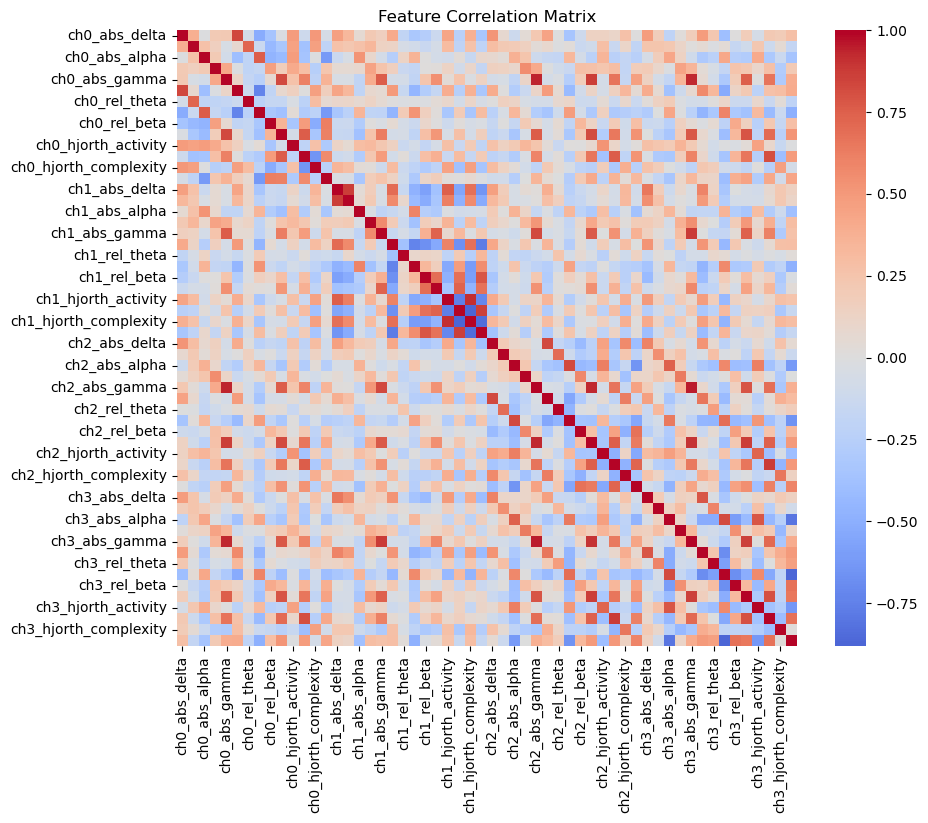

In [16]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(df_features.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

I built a representation of:
* Oscillation strength
* Oscillation proportion
* Signal speed
* Signal irregularity
* Frequency disorder

A low-level EEG description.

**Why extract features?**

Raw signal is better when:
* You have large dataset
* You want highest possible accuracy
* You don’t care about interpretability

Since interpretability is important classical machine learning with neuroscientific descriptors makes this process interpretable

It is:
* Data efficient
* Interpretable
* Dimensionality Reduction

|Approach     |Pros                           |Cons                                   |
|-------------|-------------------------------|---------------------------------------|
|Feature-based|Interpretable, stable, low data| Might miss subtle patterns            |
|Raw-signal DL|Has higher capability          |Needs lots of data, harder to interpret|

## Dataset Builder 

The data does not come with labels however it was specified how to indenitfy the files and what was the expirement about.
With that information we can create our labels.

In [17]:
def build_dataset(
    experiments,
    experiment_to_label,
    trim_df,
    fs,
):
    """
    Build feature matrix, labels, and subject groups from experiment files.
    """

    X_all = []
    y_all = []
    groups_all = []

    for ex_key, label in experiment_to_label.items():

        if ex_key not in experiments:
            continue

        for meta in experiments[ex_key]:

            subject = meta["subject"]
            session = meta["session"]
            file_path = meta["path"]

            # ---- Load + preprocess ----
            eeg_proc = load_and_preprocess(
                file_path,
                trim_df,
                subject=subject,
                experiment=int(ex_key[2:]),  # Extract numeric part from "ex01"
                session=session,
            )

            # ---- Epoch ----
            epochs = epoch_eeg(eeg_proc, fs=fs)

            # ---- Feature extraction ----
            X = extract_features(epochs, fs=fs)

            # ---- Labels ----
            y = np.full(len(X), label)

            # ---- Subject groups ----
            groups = np.full(len(X), subject)

            X_all.append(X)
            y_all.append(y)
            groups_all.append(groups)

    X_all = np.vstack(X_all)
    y_all = np.concatenate(y_all)
    groups_all = np.concatenate(groups_all)

    return X_all, y_all, groups_all

In [18]:
from eeg_organizer import parse_experiments

# obtain experiments metadata from raw directory
experiments = parse_experiments(raw_dir)

# Build eyes open vs closed dataset
experiment_to_label = {
    "ex01": 0,  # Eyes Open
    "ex02": 1,  # Eyes Closed
}

X, y, groups = build_dataset(
    experiments,
    experiment_to_label,
    trim_df,
    fs=200
)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels:", np.unique(y))

unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

X shape: (14262, 56)
y shape: (14262,)
Unique labels: [0 1]
{np.int64(0): np.int64(7136), np.int64(1): np.int64(7126)}


In [19]:
# subjects_array: length = n_epochs, values = subject IDs (1–20)
# experiments_array: length = n_epochs, values = 0 for ex01, 1 for ex02

# Build a DataFrame
df = pd.DataFrame({
    "subject": groups,      # if you returned subject IDs per epoch
    "experiment": y         # 0 = Eyes Open (ex01), 1 = Eyes Closed (ex02)
})

summary = df.groupby(["subject", "experiment"]).size().unstack(fill_value=0)
summary.index.name = "Subject"
summary.columns = ["Eyes Open (ex01)", "Eyes Closed (ex02)"]

# Total epochs per subject
summary["Total"] = summary.sum(axis=1)

# Print nicely
print(summary)

# Optional: total across all subjects
print("\nTotal epochs overall:")
print(summary[["Eyes Open (ex01)", "Eyes Closed (ex02)"]].sum())

         Eyes Open (ex01)  Eyes Closed (ex02)  Total
Subject                                             
1                     357                 357    714
2                     357                 357    714
3                     357                 357    714
4                     357                 357    714
5                     357                 357    714
6                     357                 357    714
7                     357                 343    700
8                     357                 357    714
9                     357                 357    714
10                    357                 357    714
11                    357                 357    714
12                    357                 357    714
13                    357                 357    714
14                    357                 357    714
15                    357                 357    714
16                    357                 357    714
17                    357                 357 

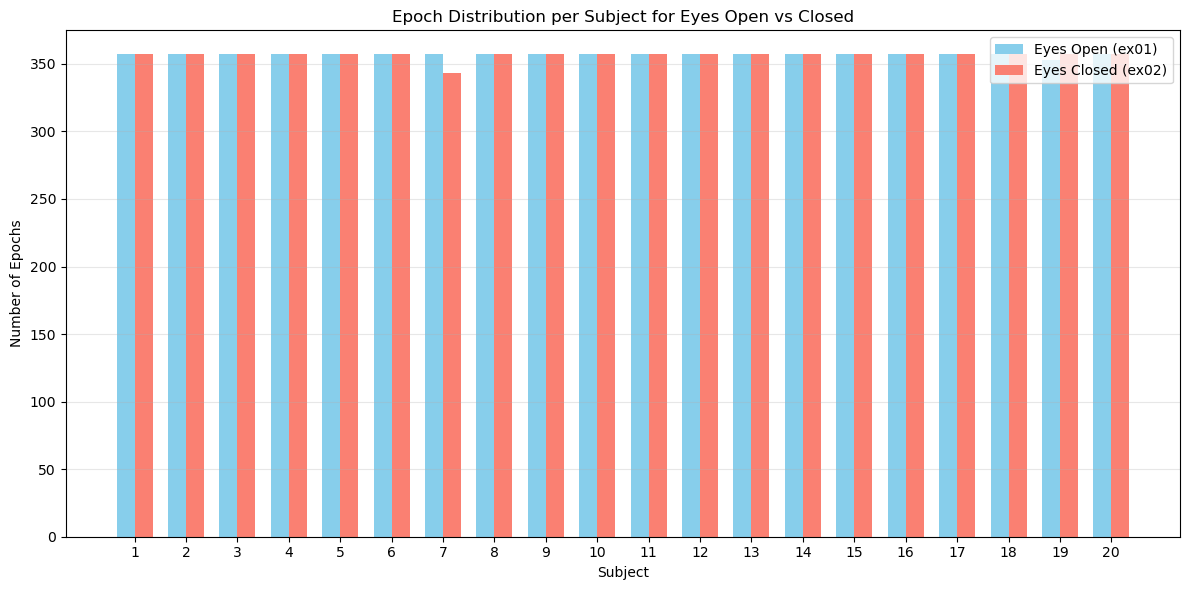

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width and positions
width = 0.35
x = np.arange(len(summary))

# Plot each condition
ax.bar(x - width/2, summary["Eyes Open (ex01)"], width, label="Eyes Open (ex01)", color='skyblue')
ax.bar(x + width/2, summary["Eyes Closed (ex02)"], width, label="Eyes Closed (ex02)", color='salmon')

# Labels & titles
ax.set_xlabel("Subject")
ax.set_ylabel("Number of Epochs")
ax.set_title("Epoch Distribution per Subject for Eyes Open vs Closed")
ax.set_xticks(x)
ax.set_xticklabels(summary.index)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5️⃣ Classification Model

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import make_scorer, recall_score

# Z-score normalization within each subject to reduce inter-subject variability
def zscore_within_subject(X, groups):
    X_z = np.zeros_like(X)
    
    unique_subjects = np.unique(groups)
    
    for subj in unique_subjects:
        idx = groups == subj
        X_sub = X[idx]
        
        mean = X_sub.mean(axis=0)
        std = X_sub.std(axis=0)
        
        # Avoid divide by zero
        std[std == 0] = 1.0
        
        X_z[idx] = (X_sub - mean) / std
        
    return X_z

X_z = zscore_within_subject(X, groups)

# Sensitivity = recall for positive class (1)
sensitivity = make_scorer(recall_score, pos_label=1)

# Specificity = recall for negative class (0)
specificity = make_scorer(recall_score, pos_label=0)
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=500,
        class_weight="balanced",
        random_state=42
    ))
])

cv = GroupKFold(n_splits=5)

scores = cross_validate(
    logreg_pipeline,
    X_z,
    y,
    groups=groups,
    cv=cv,
    scoring={
        "sensitivity": sensitivity,
        "specificity": specificity,
        "roc_auc": "roc_auc"
    }
)

print("Sensitivity per fold:", scores["test_sensitivity"])
print("Mean Sensitivity:", scores["test_sensitivity"].mean())

print("Specificity per fold:", scores["test_specificity"])
print("Mean Specificity:", scores["test_specificity"].mean())

print("ROC AUC per fold:", scores["test_roc_auc"])
print("Mean ROC AUC:", scores["test_roc_auc"].mean())

Sensitivity per fold: [0.66736695 0.79201681 0.63165266 0.73459384 0.781471  ]
Mean Sensitivity: 0.7214202512688244
Specificity per fold: [0.64985994 0.76680672 0.61764706 0.69522472 0.82072829]
Mean Specificity: 0.7100533471815693
ROC AUC per fold: [0.70742267 0.85125962 0.64587404 0.78106362 0.88669626]
Mean ROC AUC: 0.774463242853654


In [ ]:
logreg_pipeline.fit(X, y)
importances = logreg_pipeline.named_steps["clf"].coef_[0]
feature_names = get_feature_names(n_channels=epochs.shape[2])
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})
feat_imp_df = feat_imp_df.sort_values("importance", ascending=False)
feat_imp_df.head(10)

,feature,importance
14,ch1_abs_delta,4.196983
35,ch2_rel_alpha,1.736562
52,ch3_hjorth_activity,1.621760
49,ch3_rel_alpha,1.156657
33,ch2_rel_delta,0.999001
34,ch2_rel_theta,0.842588
38,ch2_hjorth_activity,0.780905
36,ch2_rel_beta,0.622036
48,ch3_rel_theta,0.572922
39,ch2_hjorth_mobility,0.565811


In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

cv = GroupKFold(n_splits=5)

scores_rf = cross_validate(
    rf_pipeline,
    X_z,
    y,
    groups=groups,
    cv=cv,
    scoring={
        "sensitivity": sensitivity,
        "specificity": specificity,
        "roc_auc": "roc_auc"
    }
)

print("Sensitivity per fold:", scores_rf["test_sensitivity"])
print("Mean Sensitivity:", scores_rf["test_sensitivity"].mean())

print("Specificity per fold:", scores_rf["test_specificity"])
print("Mean Specificity:", scores_rf["test_specificity"].mean())

print("ROC AUC per fold:", scores_rf["test_roc_auc"])
print("Mean ROC AUC:", scores_rf["test_roc_auc"].mean())

Sensitivity per fold: [0.70028011 0.80252101 0.58963585 0.70728291 0.87623762]
Mean Sensitivity: 0.7351915023435117
Specificity per fold: [0.65056022 0.81302521 0.69747899 0.73876404 0.86344538]
Mean Specificity: 0.7526547697730778
ROC AUC per fold: [0.71784915 0.88608188 0.69160581 0.78926339 0.93937922]
Mean ROC AUC: 0.8048358894321298


In [27]:
rf_pipeline.fit(X, y)
importances = rf_pipeline.named_steps["clf"].feature_importances_
feature_names = get_feature_names(n_channels=epochs.shape[2])
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})
feat_imp_df = feat_imp_df.sort_values("importance", ascending=False)
feat_imp_df.head(10)

,feature,importance
18,ch1_abs_gamma,0.081086
25,ch1_hjorth_mobility,0.038442
23,ch1_rel_gamma,0.033367
24,ch1_hjorth_activity,0.032148
17,ch1_abs_beta,0.030191
35,ch2_rel_alpha,0.026947
21,ch1_rel_alpha,0.025077
11,ch0_hjorth_mobility,0.022972
38,ch2_hjorth_activity,0.022821
26,ch1_hjorth_complexity,0.022349
